<img src="images/logo/selene-logo-640.png" style="max-height:75px;" alt="SELENE Logo" />

**Disclaimer:** This Jupyter Notebook contains content generated with the assistance of AI. While every effort has been made to review and validate the outputs, users should independently verify critical information before relying on it. The SELENE notebook repository is constantly evolving. We recommend downloading or pulling the latest version of this notebook from Github.

# Sinusoidal Positional Encodings (Original Transformer)

The Transformer architecture, introduced in the original Transformer paper [*"Attention Is All You Need"*](https://arxiv.org/pdf/1706.03762.pdf), requires positional encodings because it lacks the sequential structure inherent to earlier models like RNNs or CNNs. Unlike those models, which process inputs in order or use convolutional filters over local neighborhoods, the Transformer processes all tokens in a sequence simultaneously. This parallelism offers speed and scalability, but it also means the model does not inherently understand the order of tokens in a sentence—something that's crucial for understanding natural language. To address this, positional encodings are added to the input embeddings to provide a sense of position or order.

Positional encodings are vectors added to the word embeddings to incorporate information about each word's position in the sequence. These encodings allow the model to differentiate between, for example, *"the cat chased the dog"* and *"the dog chased the cat"*. Without positional information, both sentences would appear identical to the model since the same set of words would be present, just in a different order. By adding unique positional vectors to each word embedding, the model can learn to associate different meanings with different positions.

The original Transformer architecture uses absolute positional encodings based on **sinusoidal functions**. For each position in the input sequence, a corresponding positional encoding vector is generated using sine and cosine functions at varying frequencies. This means that each position is mapped to a unique combination of values across the embedding dimensions. Even-numbered dimensions use sine functions, and odd-numbered ones use cosine functions. The wavelength of these functions increases exponentially across dimensions, enabling the model to capture both short- and long-range positional relationships.

This method of encoding has several advantages. First, it is **deterministic and fixed**, so it does not require learning additional parameters, which helps when dealing with long sequences or limited training data. Second, the sinusoidal form allows the model to easily **compute relative positions**, because the positional difference between tokens is reflected in a predictable way through trigonometric identities. As a result, the model gains the ability to understand not just where a token is, but how far it is from another token—an important feature in many language tasks.

### Setting up the Notebook

#### Make Required Imports

This notebook requires the import of different Python packages but also additional Python modules that are part of the repository. If a package is missing, use your preferred package manager (e.g., [conda](https://anaconda.org/anaconda/conda) or [pip](https://pypi.org/project/pip/)) to install it. If the code cell below runs with any errors, all required packages and modules have successfully been imported.

In [1]:
from src.utils.plotting.posenc import *
from src.utils.libimports.posenc import *

#### Preliminaries

Before introducing you to the Transformer architecture, there are a few preliminary comments to outline the scope of this notebook:

* To make all visualizations, examples, and descriptions easier to understand, we assume that any input text is tokenized into proper words. Note that practical Transformer-based models typically rely on subword-based tokenizers (e.g., Byte-Pair Encoding, WordPiece).

With these clarifications out of the way, let's get started...

---

## Quick Recap: Absolute Positional Encodings

Absolute positional encodings are a method used in Transformer models to provide information about the position of each token in a sequence. Since Transformers process all tokens simultaneously rather than sequentially, they have no inherent understanding of word order. Absolute positional encodings solve this by assigning a unique, fixed vector $\mathbf{p}_i$ to each position $i$ in the input sequence. These vectors are then added to the word embeddings $\mathbf{w}_i$ before being passed into the model, resulting the new new embedding vectors $\mathbf{e}_i$ that are passed to the model; the figure below illustrates this idea.

<img src="images/illustrations/posenc/posenc-absolute-basic-idea.png" style="margin:auto;max-width:600px;width:100%" alt="Absolute Positional Encoding: Basic Idea">

where $L$ is the length of the sequence.

The question is now: How do we find good choices for $\mathbf{p}_i$, and what do we mean by "good" in the first place? Regarding the latter, we outline some required and desired characteristics for good positional embedding vectors in the overview notebook to positional encodings. The following list summarizes those characteristics in the context of absolute encodings:

* **Uniqueness and consistency:** Each individual positional information needs to be represented by a unique embedding vector, i.e.,two positions should not be represented by the same vector, and they should be the same for different sequence lengths.

* **Order sensitivity:** Positional encodings must capture word order, meaning that good encodings have the ability to capture relative information. In the case of absolute positional encodings, the encoding scheme should implicitly allow the model to learn and infer relative distances between words.

* **Extrapolability:** A robust positional encoding scheme should be able to generalize to sequences longer than those encountered during training. This is critical for real-world applications where input lengths can vary significantly.

* **"Small" values:** The values of the positional embeddings vectors should be small so they do not dominate the semantic information captured by the word embedding vectors. This requirement is typically trivial to satisfy.

* **Scalability:** The encoding method should be computationally efficient, especially for very long sequences or large datasets.

Before explore the position encoding scheme proposes in the original [Transformer paper](https://arxiv.org/pdf/1706.03762.pdf), let's briefly look at naive encoding schemes better that are arguably "not good" to better understand the required and desired characteristics. The first alternative simply set all elements in the vector for encoding position $i$ to $i$ itself &mdash; that is, $\mathbf{p}_{ij} = i$, where $\mathbf{p}_{ij}$ is the $j$-th vector element of the positional embedding vector at position $i$. The figure below illustrates this method.

<img src="images/illustrations/posenc/posenc-absolute-naive-approach-01.png" style="margin:auto;max-width:600px;width:100%" alt="Absolute Positional Encoding: Naive Approach 1">

While all $\mathbf{p}_i$ are unique and easy to compute for arbitrary sequence lengths $L$, notice that the absolute size of the values in the embedding vectors $\mathbf{p}_i$ depends on $L$. This means that for long(er) sequences, the positional encodings become larger and larger vectors. Assuming that word embedding vectors are typically normalized (e.g., into the range $-1$ to $+1$ like shown in the example), the positional encodings $\mathbf{p}_{i}$ quickly start to dominate the final embedding vectors $\mathbf{e}_{i}$, more and more obfuscating the semantic information captured by the word embedding vectors $\mathbf{w}_{i}$. Well, so why not just force all values into a fixed range using normalization. For example, we can ensure that all positional embedding vectors using the previous approach are between $0$ and $+1$ by calculating $\mathbf{p}_{ij} = i/(L-1)$; see the figure below illustrating this normalization attempt.

<img src="images/illustrations/posenc/posenc-absolute-naive-approach-02.png" style="margin:auto;max-width:600px;width:100%" alt="Absolute Positional Encoding: Naive Approach 2">

This normalization approach ensures that positional embeddings vectors no longer run the risk of dominating the word embedding vectors.  However, because the values do now depend on the sequence length $L$, the encodings are no longer unique. This means that the vector $\mathbf{p}_i$ will be different for two sequences that do not have the same length. However, we require that all $\mathbf{p}_{i}$ should always be the same vector encoding position $i$.

As these two naive encoding schemes show, it is not obvious how to derive good positional embedding vectors.

---

## Absolute Positional Encoding Using Sinusoidal Functions

### Preliminary Approach: Binary Encodings

To better motivate and appreciate the positional encoding scheme using sinusoidal functions as proposed in the original [Transformer paper](https://arxiv.org/pdf/1706.03762.pdf), let's first consider another alternative and simple approach using binary encodings. For example, since the binary representation $23$ is `010111` &mdash; assuming 6-dimensional embedding space &mdash; we would encode the corresponding positional embedding vector as

$$\large
\mathbf{p}_i = [0, 1, 0, 1, 1, 1]^\top
$$

As long as our embedding space with $d$ dimensions is large enough to capture all values from $0$ to $L-1$ (i.e., $2^d > L$), it is easy to see that each embedding vector $\mathbf{p}_i$ will be unique for each position $i$. The vectors are also trivial to compute and all vector values are naturally limited to $1$ (which could even be lowered by some scaling factor). In the code cell below, we provide an auxiliary method `visualize_binary_encodings()` that illustrates the idea. The x-axis marks the position $i$ in a sequence, and then reads out the binary representation starting with the least significant bit on top.

**Your turn:** Change the argument `pos=23` to a different value between $0$ and $50$ (exclusive) and see how the y-axis will always reflect the binary representation of the position. You can also remove the `pos` argument completely to show a random position each time to run the code cell.

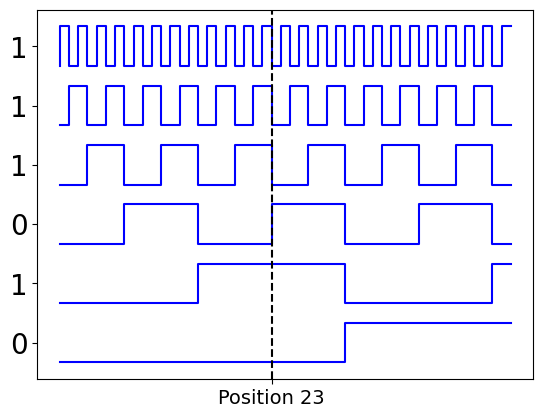

In [2]:
visualize_binary_encodings(pos=23)
#visualize_binary_encodings() # generate plot for a random position

While this binary encoding scheme features some of the more straightforward characteristics, it still has some more subtle problems. Firstly, all the values in the embedding vectors are either $0$ or $1$ &mdash; in other words, the vectors contain only **discrete values**. However, the gradient descent algorithm for training neural networks prefers smooth and continuous values because it relies on the ability to compute gradients &mdash; the derivatives of the loss function with respect to the model's parameters. Although the positional embedding vectors are fixed and not updated themselves, the combined embedding vectors $\mathbf{e}_i$ do not change smoothly. This makes it harder for the model to learn.

And secondly, the binary embedding vectors fail to implicitly capture relative distances. It is useful that two positional embedding vectors at *different absolute positions*, but with the *same relative position*, have the same dot product because this property helps the model capture relative position information, which is often more important than absolute position in many tasks (like language modeling or translation). In a Transformer, the attention mechanism uses dot products between token embeddings (including positional encodings) to compute relationships between tokens. If the dot product between positions depends only on relative distance, then the model can more easily generalize across sequences of different lengths or positions. For example, it can learn patterns like "the next word is likely to be a verb" regardless of whether that pattern appears at the beginning or end of a sentence. This position-invariance supports tasks where the meaning of word relationships is relative rather than fixed, making the model more flexible and robust.

To briefly illustrate this, the code cell computes the dot products between different binary embedding vectors for random pairs of positions between $10$ and $30$. Although the absolute positions are random, the distance between the two positions is always the same. The method `int_to_binary_array()` is a simple auxiliary method we provide to convert any integer to its binary representation as an array.

In [3]:
distance = 10

for _ in range(5):
    rnd_pos =  torch.randint(10, 30, (1,)).item()
    p1 = int_to_binary_array(rnd_pos, 100)
    p2 = int_to_binary_array(rnd_pos+distance, 100)
    print(f"The dot product between p_{rnd_pos} and p_{rnd_pos+distance} (distance: {distance}) is {p1.dot(p2):.3f}")

The dot product between p_21 and p_31 (distance: 10) is 3.000
The dot product between p_17 and p_27 (distance: 10) is 2.000
The dot product between p_27 and p_37 (distance: 10) is 1.000
The dot product between p_17 and p_27 (distance: 10) is 2.000
The dot product between p_21 and p_31 (distance: 10) is 3.000


The output of the previous code cell shows us two things. For one &mdash; apart from some lucky chance &mdash; the result of the dot product will not all be the same; and they will also change if you run the code cell multiple times. In other words, binary embedding vectors fail to implicitly capture relative distances a model may learn. And also, the dot products are again all discrete values. While, of course, the positional embedding vectors are first added to the continuous word embedding vectors, they introduce a "discrete component" which can make it harder for the model to learn.

So, given that binary encodings show some useful behavior, can we replace these discrete functions &mdash; see the previous &mdash; with smoothing in such a way that we can further get rid of the limitations of binary embedding vectors. The answer is "yes", which will now bring us to the actual positional encoding scheme first introduced with the Transformer architecture.

### Encoding Using Sine & Cosine

The original Transformer paper [*"Attention Is All You Need"*](https://arxiv.org/pdf/1706.03762.pdf) proposed an absolute positional encodings scheme using sinusoidal function (i.e., sine and cosine) to calculate the positional embedding vectors. This means that the positional encodings are fixed and not learned, which makes them &mdash; at least in principle &mdash; easier to generalize to positions larger than seen during training. More specifically, the an individual value $\mathbf{p}_{ij}$ in an embedding vector is calculated as

$$\large
\mathbf{p}_{ij} = 
\begin{cases} 
\sin \left( \frac{i}{10000^{2j/d_{model}}} \right) & \text{if } j \text{ is even},\\[0.75em]
\cos \left( \frac{i}{10000^{2(j-1)/d_{model}}} \right) & \text{if } j \text{ is odd}
\end{cases}
$$

where $\mathbf{p}_{ij}$ again represents the $j$-th entry/element of the positional embedding vector for position $i$. In other words, a single vector value not only depends on the position but also if the corresponding index of the vector is an even or odd index.

Like for the binary encodings, we provide an auxiliary method `visualize_sinusoidal_encodings(pos=23)` to illustrate this approach of using sine and cosine functions to compute all positional embedding vectors. Again, you can run the code cell below with different values between $0$ and $50$ (exclusive), or without the `pos` argument for a random position. The x-axis indicates the position, and the values on the y-axis represent the result embedding vector &mdash; as before, we limit ourselves to 6-dimensional embedding vectors.

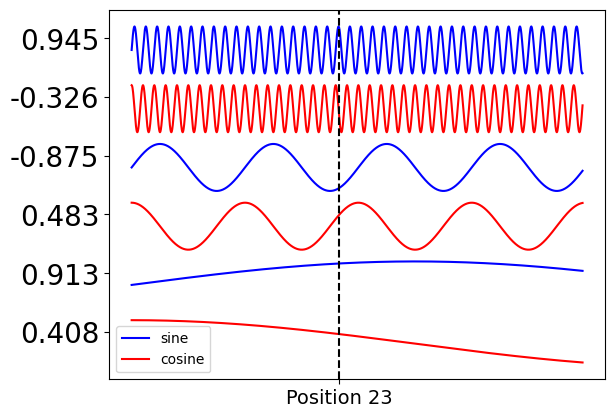

In [4]:
visualize_sinusoidal_encodings(pos=23)
#visualize_sinusoidal_encodings() # generate plot for a random position

First and foremost, notice the similar "nature" of this plot compared to the one for the binary encodings. Here, the bits at higher positions are represented by sine and cosine waves with lower frequencies. However, the effect is the same to ensure that the resulting embedding vector for each position is unique &mdash; of course, compared to the binary encodings, it is not as obvious why this is the case. Let's have a look at te value

$$\large
\frac{i}{10000^{2j/d_{model}}}
$$

used for the sine and cosine function. The constant $10,000$ represents the **base** to control the range of frequencies; in the both original [Transformer paper](https://arxiv.org/abs/1706.03762), the base frequency is set to $10,000$ &mdash; although other works used different, typically higher, values for better results. The exponent $2j/d_{model}$ scales the input so that lower dimensions correspond to higher-frequency sinusoids (rapid changes), and higher dimensions correspond to lower-frequency sinusoids (slow changes). This spread of frequencies allows the model to represent both fine-grained (local) and coarse-grained (global) positional relationships. This combination of lower-frequency and higher-frequency sinoids &mdash; including the use sine and cosine &mdash; ensures that:

* All positional embedding vectors are **unique** across all positions, including positions beyond those seen during training.

* This encoding scheme ensures that the dot product between two position embedding vectors is the same for the same distance between the two positions; we show this using an example later. This means this scheme (at least) implicitly captures **relative distances** between words.

**Note:** Both these characteristics are not obvious but can be mathematically proven. However, this is beyond the scope of this notebook.

This proposed encoding scheme is easy to implement for two main reasons. Firstly, as this scheme explicitly encodes absolute positions, the positional embeddings are added to the word embeddings before being passed to the Transformer architectures. In contrast relative positional encodings typically are typically part of the attention mechanism itself, making their integration more challenging. And secondly, the proposed scheme is fixed, i.e., all positional embedding vectors are generated based on deterministic functions and are not learned. In other words, the positional encodings behave more like a constant.

The class `PositionalEncoding` in the code cell below provides a basic implementation of absolute positional encodings using sinusoidal functions as a PyTorch module. This class can be used "as is" as part of a Transformer-based model to add positional encodings to word embedding vectors to serve as input of the actual Transformer.

In [5]:
class PositionalEncoding(nn.Module):

    def __init__(self, d_model, L_max=1000):
        super().__init__()
        # (1) Initialize a tensor holding all values for each position 0..(max_len01) and each dimension 0..(d_model-1)
        pe = torch.zeros(L_max, d_model)
        # (2) Create array with all positions [0, 1, 2, ..., (max_len-1)]
        position = torch.arange(0, L_max, dtype=torch.float).unsqueeze(1)
        # (3) Compute all possible i/(10000^(2j/d_model)) values
        dimensions = torch.arange(0, d_model, 2).float()
        div_term = (1 / torch.pow(10000, (dimensions / d_model)))
        # (4) Compute sinusoidal functions
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        # (5) Add batch dimension
        pe = pe.unsqueeze(0)
        # (6) Register tensor as part of model
        self.register_buffer("pe", pe)

    def forward(self, X):
        # Get required positional embedding vectors
        pos_enc = self.pe[:,:X.size(1)]
        # Add positional encoding to input vector (typicall a word embedding vector)
        out = X + pos_enc
        # Here only return the positional encoding to inspect it (not needed in practice)
        return out, pos_enc

As the positional encodings are fixed and no further learning is involved, all the import computations are done in the `__init__()` method. The two input arguments are $d_{model}$ (i.e., the size of the input and output embedding vectors of the Transformer) as well as the maximum sequence length $L_{max}$. Transformer-based models are trained with a maximum sequence length primarily due to computational and architectural constraints. The core operation in Transformers &mdash; the attention mechanism &mdash; has a time and memory complexity that scales quadratically with the input sequence length. This means that doubling the sequence length quadruples the resources needed, making it computationally expensive and inefficient to handle very long sequences. To keep training feasible and within hardware limits, a fixed maximum sequence length is set during training. This allows us to precomputed all possible encoding vectors using the following steps:

* **(1) Initialize positional encodings:** Knowing $d_{model}$ and $L_{max}$, we can initialize a tensor to hold positional embedding vectors.

* **(2) Create all positions:** Based on the maximum sequence length, we can generate an array $[0, 1, 2, \dots, (L_{max}\!-\!1)]$. The `arange()` method creates a 1-dimensional tensor with evenly spaced values within a specified range. Its basic usage is `arange(start, end, step)`, where `start` is the beginning value (inclusive), `end` is the stopping value (exclusive), and `step` defines the spacing between values (default is 1).

* **(3) Compute constant part inputs for sinusoidal functions:** From the definition of $p_{ij}$ given above we can see that the terms $ 1/ 10000^{2j/d_{model}}$ and $1/10000^{2(j-1)/d_{model}}$ only depend on the embedding dimension $j$. This allows us to compute all required terms. Since we use $j$ for even dimensions and $j-1$ for add dimensions the factor $k$ in the term $1/10000^{2k/d_{model}}$ will always be an even number. Again, we can use the `arange()` &mdash; now with a `step` value of $2$ &mdash; method to create the array of even numbers $[0, 2, \cdots (d_{model}\!-\!2)]$. This array gives us all all $2k$ values in the term $1/10000^{2k/d_{model}}$, allowing us to calculate those terms for all `2k` storing them in array `div_term`.

* **(4) Compute sinusoidal functions:** We can now compute the final embedding vector using the sine and cosine function. Of course, both functions receive as input the product of positions $i$ and the terms $1/10000^{2k/d_{model}}$ we have both computed. Using [**array slicing**](https://en.wikipedia.org/wiki/Array_slicing), with `0::2` we match all even positions (getting the result of the sine function), and with `1::2` we match all odd positions (getting the result from the cosine function).

* **(5) Add batch dimension:** So far tensor `pe` holding all positional embedding vectors has the shape of $L_{max}\times d_{model}$. However, the expected input in the forward method are batches of shape $B\times L_{max}\times d_{model}$, where $B$ is the size of the batch (i.e., the number of sequences in the batch). Since the same positional embeddings are added to the same position across all sequences, we can use the method `unsqueeze()` to change the shape of `pe` to $1\times L_{max}\times d_{model}$. We can later rely on [**broadcasting**](https://numpy.org/doc/stable/user/basics.broadcasting.html) in the `forward()` method to add word end positional embeddings; see below.

* **(6) "Register" positional embeddings:** The [`register_buffer()`](https://docs.pytorch.org/docs/stable/generated/torch.nn.Module.html#torch.nn.Module.register_buffer) method is used to register a tensor as part of a model that should not be considered a model parameter, but still needs to be saved and moved with the model (e.g., to a GPU). It's useful for constants like masks, positional encodings, or running statistics that are important for the model's computation but should not be updated during backpropagation. When you use `register_buffer(name, tensor)`, the tensor becomes part of the model's state &mdash; it will show up in state_dict() and be saved/loaded with the model &mdash; but won't appear in model.parameters() or be affected by optimizers. This is essential for keeping important data with the model without training it.

The `forward()` method of class `PositionalEncoding` is very straightforward. The only thing we need to consider is that a current batch `X` may contain sequences shorter than the maximum length $L_{max}$. Assuming the $l$ being the length of all sequences in `X`, we first need to extract only the embedding vectors up to the $l$. This gives us a tensor of shape $1\times l \times d_{model}$, batch `X` has a shape of $B\times l \times d_{model}$. These two shapes are compatible in terms for [**broadcasting**](https://numpy.org/doc/stable/user/basics.broadcasting.html), so we can simply add them to get the final embedding vectors $\mathbf{e}_i$. Note that the `forward()` method also returns the positional embeddings; we only do this here so we can expect the embedding vectors.

To test our implementation, let's first create an example batch `X` of size `batch_size` and each sequence is of length `seq_len`. Each sequence element is a vector of length `embed_size`. This is a typical example for an input batch containing multiple sequences of word embedding vectors.

In [6]:
batch_size, seq_len, embed_size = 32, 100, 512

X = torch.rand((batch_size, seq_len, embed_size))

We can now create an instance of class `PositionalEncoding` and pass example batch `X` as input. Recall that we get two outputs: the final embedding vectors and the tensor containing only the positional encodings.

In [7]:
positional_encoding = PositionalEncoding(embed_size)

pe_out, pos_enc = positional_encoding(X)

print(f"Shape of output embedding tensor: {pe_out.shape}")
print(f"Shape of positional encoding tensor: {pos_enc.shape}")

Shape of output embedding tensor: torch.Size([32, 100, 512])
Shape of positional encoding tensor: torch.Size([1, 100, 512])


Since all sequences in example batch `X` were of length $100$ the tensor with the positional encodings naturally only includes the embedding vectors up to length $100$. Before we inspect the positional encodings, let's first remove the batch dimension using the [`squeeze()`](https://docs.pytorch.org/docs/stable/generated/torch.squeeze.html) method.

In [8]:
pos_enc = pos_enc.squeeze()

print(f"Shape of positional encoding tensor: {pos_enc.shape}")

Shape of positional encoding tensor: torch.Size([100, 512])


The purpose of inspecting the positional encodings is to run the same test as we have done for the binary encodings &mdash; that is, to look at the dot product between random pairs of positional embedding vectors that are the same distance apart. In the code cell below, we therefore replace code from before, where we randomly pick pairs of embedding vectors, only ensuring the same distance, and compute the dot product.

In [9]:
distance = 10

for _ in range(5):
    rnd_pos =  torch.randint(10, 50, (1,)).item()
    p1 = pos_enc[rnd_pos]
    p2 = pos_enc[rnd_pos+distance]

    print(f"The dot product between p_{rnd_pos} and p_{rnd_pos+distance} (distance: {distance}) is {p1.dot(p2):.3f}")

The dot product between p_32 and p_42 (distance: 10) is 173.790
The dot product between p_48 and p_58 (distance: 10) is 173.790
The dot product between p_21 and p_31 (distance: 10) is 173.790
The dot product between p_23 and p_33 (distance: 10) is 173.790
The dot product between p_23 and p_33 (distance: 10) is 173.790


As you can see &mdash; even if you run the code cell multiple times &mdash; the dot product between all vector pairs will always be the same, independent from their absolute position. This means that this encoding scheme &mdash; in contrast to binary encodings &mdash; allows a model to better capture relative distances during training. The property that the dot product of absolute positional embedding vectors depends only on the relative distance between words is highly beneficial because it inherently captures the notion of proximity and order in sequences without introducing artificial biases based on absolute positions. This means that the model can generalize better to sequences of varying lengths, as the relationships between words remain consistent regardless of where they appear in the input. It also allows the model to learn local dependencies effectively, as the strength of the interaction between two words is directly related to how close they are to each other, mirroring how human language often functions.

---

## Discussion

### The Theory Behind Positional Encodings

Throughout this notebook, we have seen that the proposed approach of creating absolute positional encodings using sinusoidal function ensures that (a) the embedding vectors are unique for each position, and (b) that the dot product between embedding vectors only depends on the relative distance. While both statements are true, we skipped their theoretical foundation to keep the notebook simple. The key idea is that the encoding at each position is constructed using sinusoids of different frequencies, which create patterns that are phase-shifted versions of each other for different positions. This allows the dot product between any two positional vectors to primarily depend on how far apart the positions are, rather than their absolute values. But again, a more formal exploration of these characteristics was beyond the scope of this notebook.

### Positional Encodings &mdash; Alternatives

Absolute positional encodings using sinusoidal functions provide a deterministic and unique encoding for each position, ensuring that the model always knows the exact location of a word in the sequence. Because sine and cosine functions are periodic and continuous, the model can infer positional relationships for unseen, longer sequences by extrapolating the patterns learned from shorter ones. Finally, the choice of sine and cosine functions with varying frequencies enables the model to *potentially* learn to attend to relative positions. 

However, sinusoidal positional encodings also come with certain limitations. One major drawback is their fixed and predefined nature. The sinusoidal form imposes a specific, rigid structure on positional relationships that might not always be optimal for all tasks or data types. Unlike **learned positional embeddings**, they cannot adapt to the specific characteristics of the training data or the downstream task, potentially limiting their expressiveness for nuanced positional information. Another limitation is that while they are designed to facilitate the learning of relative positions, they are **inherently absolute** encodings. This means that if the same phrase or sentence is shifted to a different absolute position within a longer sequence, its positional encoding will change, potentially leading to different attention patterns. While the model can learn to account for this, it can sometimes be less intuitive than approaches that directly encode relative positions.

Furthermore, some research suggests that the benefits of sinusoidal encodings for extrapolation to significantly longer sequences than observed during training might not be as strong in practice as theoretically expected. While they can generate encodings for arbitrary lengths, the model's ability to effectively utilize this information for extremely long, unseen sequences can **still be limited**. This is because the attention mechanism might struggle to maintain precise positional relationships over very vast distances, even with the continuous nature of sinusoidal functions. 

Despite these limitations, sinusoidal positional encodings remain a widely adopted and effective method for incorporating positional information into Transformer models due to their simplicity, determinism, and ability to generalize to varying sequence lengths. That being said, various alternatives of positional encodings have been proposed and are used in practice. Here are some of the more common and popular examples:

* **Learned Positional Embeddings**: Instead of using fixed sinusoidal values, models learn positional embeddings just like token embeddings. Each position in the sequence is associated with a trainable vector. This approach allows the model to adapt positional representations to the task at hand, often improving performance. However, it limits generalization to longer sequences than seen during training.

* **Relative Positional Encodings**: These encodings represent the distance between tokens rather than their absolute positions. One widely used method is **relative attention**, introduced in Transformer-XL and further developed in models like T5 and DeBERTa. Relative encodings allow the model to better handle longer sequences and to generalize more flexibly by focusing on token relationships regardless of their position in the sequence.

* **Rotary Positional Embeddings (RoPE)**: Used in models like GPT-NeoX and LLaMA, RoPE applies position-dependent rotations to token embeddings. It enables attention mechanisms to inherently encode relative positions while maintaining the benefits of absolute encodings. RoPE supports extrapolation to longer sequences and has been shown to be effective in autoregressive tasks.

It is important to note that no positional encoding scheme is perfect because each approach makes trade-offs between generalization, efficiency, and task-specific performance. Fixed encodings like sinusoidal functions are lightweight and allow models to generalize to unseen sequence lengths, but they cannot adapt to the specific data or task, potentially limiting performance. Learned positional embeddings offer task-specific flexibility but are constrained by the maximum sequence length seen during training and can struggle to generalize to longer inputs. Relative encodings and techniques like Rotary Positional Embeddings improve generalization and capture position-independent relationships, which are often more relevant in language tasks. However, they can be more complex to implement and computationally expensive. Ultimately, the effectiveness of a positional encoding depends on the context—no single method excels across all domains or use cases, and choosing one involves balancing the trade-offs between generality, performance, and scalability.

---

## Summary

The original Transformer paper [*"Attention Is All You Need"*](https://arxiv.org/pdf/1706.03762.pdf) introduced the use of sinusoidal positional encodings to inject information about word positions into the model. The authors proposed using a combination of sine and cosine functions at different frequencies to create **fixed** (non-learnable) vectors that are added to the input embeddings. Each position in the sequence has a unique encoding, but the encoding function is deterministic and independent of the data.

The key idea behind sinusoidal encodings is that they allow the model to **generalize to longer sequences** than seen during training. Because these encodings are continuous and periodic, they support extrapolation to unseen positions. Moreover, the design ensures that the **relative positions** between tokens are preserved through properties of trigonometric functions &mdash; the dot product between two positional vectors depends only on the distance between them, not their absolute values. This helps the attention mechanism focus on relative positions, which are often more semantically meaningful.

Despite these advantages, several limitations led to improvements in later work. One issue is that **fixed encodings are not data-adaptive**, potentially limiting their expressiveness. To address this, many later models &mdash; like BERT and GPT &mdash; use **learned positional embeddings**, where position vectors are trained along with the rest of the model. This allows the model to optimize positional representations for specific tasks, often yielding better empirical performance, though with limited extrapolation ability.

More recent approaches aim to combine the benefits of both fixed and learned encodings. For instance, **relative positional encodings** (e.g., in Transformer-XL and T5) directly model the distance between tokens, allowing the attention mechanism to focus on relative rather than absolute positions. Others, like RoPE (Rotary Positional Embedding), embed positions through **rotations in embedding space**, preserving relative distances while maintaining compatibility with dot-product attention. These methods help models generalize better, handle longer contexts, and capture the structure of sequences more effectively.

In summary, while sinusoidal positional encodings introduced a simple and effective way to handle token order using absolute positions, ongoing research has expanded on this foundation by exploring learned, relative, and hybrid encodings to enhance flexibility, generalization, and performance across diverse NLP tasks.